In [2]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl

from functools import partial

import time
import scipy.stats as stats
import seaborn as sns
#import arviz as az

#import constants

from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_columns', None)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

/opt/anaconda3/envs/post_boda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/sq/pxxh686s20scbcsrvq340czj6yvqp0/T/ipykernel_21106/3176591248.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [4]:
def propeller_dot_plot(point_array,
                       title=None,
                       axis_labels=None,
                       R=10,
                       figsize=(10,8),
                       min_color=-4,
                       max_color=4,
                       cmap=mpl.cm.coolwarm,
                       axis_color='black',
                       soft_guideline_color='lightgrey',
                       mid_guideline_color='grey',
                       soft_guideline_stlye='--',
                       mid_guideline_stlye='--',
                       soft_guideline_width=1,
                       mid_guideline_width=1,
                       label_padding = 1.5,
                       axis_arrow_head_scale=0.025,
                       axis_label_fontsize=20,
                       title_fontsize=28,
                       title_y = 1.08,
                       colorbar_label=None,
                       colorbar_aspect=20,
                       colorbar_shrink=0.5,
                       dot_alpha=0.1,
                       rasterized=True,
                       dot_size=15,
                       color_list=None,
                       colorbar=True,
                       axis_colors=['#00A79D', '#FBB040', '#ED1C24']
                      ):
    
    x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
    floor_R =  np.floor(R)
    floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))

    fig, ax = plt.subplots(figsize=figsize)
    plt.axis('equal')
    
    #--- Get coloring for minimum
    if color_list is None:
        #min_color, max_color = point_array.min(axis=1).min(), point_array.min(axis=1).max()
        color_values = point_array.min(axis=1)
        norm = mpl.colors.Normalize(vmin=min_color, vmax=max_color)
        color_list = cmap(color_values)

    #--- Remove frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #---Remove ticks
    plt.xticks([])
    plt.yticks([])

    #--- Line guides
    plt.plot( [0, 0], [0, -floor_R], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
    plt.plot([0, floor_x1], [0, floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
    plt.plot([0, -floor_x1], [0,  floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
    
    plt.plot([0, floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
    plt.plot([0, -floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

    plt.plot([0, -floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
    plt.plot([0, floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

    plt.plot([0, -floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
    plt.plot([0, floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

    #--- Circles
    for radius in np.arange(1, floor_R+1):
        ax.add_patch(plt.Circle((0,0), radius, color=soft_guideline_color, fill=False,
                                linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1))

    #--- Main axes
    plt.arrow(0, 0, 0, R, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2, linewidth=mid_guideline_width)
    plt.arrow(0, 0, x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2, linewidth=mid_guideline_width)
    plt.arrow(0, 0, -x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2, linewidth=mid_guideline_width)
    
    if axis_labels:
        plt.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize, color=axis_colors[0], fontweight='bold')
        plt.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize, color=axis_colors[1], fontweight='bold')
        plt.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize, color=axis_colors[2], fontweight='bold')

    #--- Plot points
    shifted_points = point_array - point_array.min(axis=1)[:, None]
    
    Xs = []
    Ys = []
    for row in range(shifted_points.shape[0]):
        point = shifted_points[row, :]
        min_dim = point.argmin()
        max_dim = point.argmax()

        mid_dim = [0, 1, 2]
        mid_dim.remove(min_dim)
        mid_dim.remove(max_dim)
        mid_dim = mid_dim[0]

        temp_r = point[max_dim]
        temp_theta_shift = 60 * point[mid_dim] / point[max_dim]
        if max_dim == 0:
            if mid_dim == 1:
                temp_theta = 90 + temp_theta_shift
            elif mid_dim == 2:
                temp_theta = 90 - temp_theta_shift
        elif max_dim == 1:
            if mid_dim == 0:
                temp_theta = 210 - temp_theta_shift
            elif mid_dim == 2:
                temp_theta = 210 + temp_theta_shift
        elif max_dim == 2:
            if mid_dim == 1:
                temp_theta = 330 - temp_theta_shift
            elif mid_dim == 0:
                temp_theta = -30 + temp_theta_shift
                
        temp_x = temp_r * np.cos(np.deg2rad(temp_theta))
        temp_y = temp_r * np.sin(np.deg2rad(temp_theta))        
        Xs.append(temp_x)
        Ys.append(temp_y)

    plt.scatter(Xs, Ys, color=color_list, alpha=dot_alpha, marker='.', rasterized=rasterized, zorder=2, s=dot_size)  
    if title:
        plt.title(title, fontsize=title_fontsize, y=title_y)
    
    #--- Plot colorbar
    if colorbar:
        cax, cbar_kwds = mpl.colorbar.make_axes(ax, location = 'right',
                                  fraction=0.15, shrink=colorbar_shrink, aspect=colorbar_aspect)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
        if colorbar_label:
            cb.set_label(colorbar_label, fontsize=16)
        
    return fig, ax

In [5]:
def propeller_pie_plot(point_array,
                       inner_circle_radii=[1,4,10],
                       title=None,
                       axis_labels=None,
                       pie_colors=['#00A79D', '#FBB040', '#ED1C24'],
                       R=10,
                       figsize=(10,10),
                       label_padding = 1.5,
                       axis_label_fontsize=20,
                       title_fontsize=28,
                       title_y = 1.08,
                       sep_line_color = 'white',
                       sep_line_width = 2,
                       sep_line_style = '-',
                       mid_section_color = 'gainsboro',
                       lighting_amount = [1.1, 1.5],
                       pct_fontsize_factor = 14,
                       integer_pcts = True,
                      ):
    #--------------------- Compute percentages ----------------------------
    shifted_points = point_array - point_array.min(axis=1)[:, None] 
    
    point_dict = {'0': [],
                  '1': [],
                  '2': [],
                  '0_1': [],
                  '0_2': [],
                  '1_2': []
                 }
    for row in range(shifted_points.shape[0]):
        point = shifted_points[row, :]
        min_dim = point.argmin()
        max_dim = point.argmax()

        mid_dim = [0, 1, 2]
        mid_dim.remove(min_dim)
        mid_dim.remove(max_dim)
        mid_dim = mid_dim[0]

        temp_r = point[max_dim]
        temp_ratio = point[mid_dim] / point[max_dim]
        if temp_ratio < 0.5:
            temp_key = str(max_dim)
            point_dict[temp_key].append(point)
        elif temp_ratio >= 0.5:
            temp_key = ['0', '1', '2']
            temp_key.remove(str(min_dim))
            temp_key = '_'.join(temp_key)
            point_dict[temp_key].append(point)

    point_dict['0'] = np.stack(point_dict['0'])
    point_dict['1'] = np.stack(point_dict['1'])
    point_dict['2'] = np.stack(point_dict['2'])
    point_dict['1_2'] = np.stack(point_dict['1_2'])
    point_dict['0_2'] = np.stack(point_dict['0_2'])
    point_dict['0_1'] = np.stack(point_dict['0_1'])

    total_n_points = shifted_points.shape[0]
    pct_sum = 0
    pcts_df = pd.DataFrame(inner_circle_radii, columns=['radius'])
    for point_key in point_dict.keys():
        temp_points = point_dict[point_key]
        temp_rs = temp_points.max(axis=1)
        low_val = 0
        temp_pcts = []
        for i in range(len(inner_circle_radii)):
            high_val = inner_circle_radii[i] 
            pct = (temp_rs[temp_rs >= low_val] < high_val).sum() / total_n_points
            temp_pcts.append(pct)
            pct = np.round(pct, 3)
            pct_sum += pct
            low_val = high_val
        pcts_df[point_key] = temp_pcts
    
    #--------------------- Construct figure ----------------------------
    #inner_circle_radii = pcts_df['radius'].tolist()
    x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
    floor_R =  np.floor(R)
    floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))
    
    #--- Get gradual colors for inner circles
    pie_colors = [pie_colors[0], mid_section_color, pie_colors[1], mid_section_color, pie_colors[2], mid_section_color]
    all_pie_colors = [pie_colors]
    for i in range(len(inner_circle_radii) - 1):
        all_pie_colors.append([adjust_lightness(c, amount=lighting_amount[i]) for c in all_pie_colors[i]])
    
    #--- Begin figure
    fig, ax = plt.subplots(figsize=figsize)

    #--- Background pie
    sizes = 6*[100/6]
    for radius_idx, radius in enumerate(reversed(inner_circle_radii)):
        ax.pie(sizes, colors=all_pie_colors[radius_idx], textprops={'fontsize': 20}, # labels=labels,
            shadow=True, startangle=60, radius=radius)

    for radius in inner_circle_radii:
        ax.add_patch(plt.Circle((0,0), radius, color=sep_line_color, fill=False, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1))

    ax.axis('equal') 
    
    #--- Line guides
    plt.plot([0, floor_R], [0, 0], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)
    plt.plot([0, -floor_R], [0, 0], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)

    plt.plot([0, -floor_y1], [0, floor_x1], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)
    plt.plot([0, floor_y1], [0, floor_x1], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)

    plt.plot([0, -floor_y1], [0, -floor_x1], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)
    plt.plot([0, floor_y1], [0, -floor_x1], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)
    
    if axis_labels:
        plt.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize)
        plt.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize)
        plt.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize)
    
    #--- Pct texts
    angle_dict = {'0': 90,
                  '1': 210,
                  '2': -30,
                  '0_1': 150,
                  '0_2': 30,
                  '1_2': 270
                 }
    #- Non-center pcts
    for group_column in pcts_df.columns[1:]:
        if integer_pcts:
            temp_texts = np.round(100*pcts_df[group_column], 0).astype(int).astype(str).tolist()
            #temp_texts = np.floor(100*pcts_df[group_column]).astype(int).astype(str).tolist()
        else:
            temp_texts = np.round(100*pcts_df[group_column], 1).astype(str).tolist()
        text_theta = angle_dict[group_column] 
        low_r = inner_circle_radii[0]
        for high_r, pct_text in zip(inner_circle_radii[1:], temp_texts[1:]):
            text_r = 0.5 * (low_r + high_r)
            low_r = high_r
            text_x = np.round(text_r * np.cos(np.deg2rad(text_theta)), 2)
            text_y = np.round(text_r * np.sin(np.deg2rad(text_theta)), 2)
            if float(pct_text) == 0.0:
                fontsize = 0
            else:
                fontsize = 8 #pct_fontsize_factor * float(pct_text)**0.2
            plt.text(text_x, text_y, pct_text, ha='center', va='center', fontsize=fontsize)#, fontweight='bold')#, color='#002D72')
    #- Center pct
    if integer_pcts:
        center_pct = str(int(np.round(100*pcts_df.iloc[0][pcts_df.columns[1:]].sum(), 0)))
    else:
        center_pct = str(float(np.round(100*pcts_df.iloc[0][pcts_df.columns[1:]].sum(), 1)))
    if float(center_pct) == 0.0:
        fontsize = 0
    else:
        fontsize = 8 #pct_fontsize_factor * float(center_pct)**0.2
    plt.text(0, 0, center_pct, ha='center', va='center', fontsize=fontsize)#, fontweight='bold')#, color='#002D72')
    
    if title:
        plt.title(title, fontsize=title_fontsize, y=title_y)
        
    return fig, ax

In [5]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v3.txt', sep=" ", low_memory=False)

quality_filter = (boda2_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
boda2_df = boda2_df[quality_filter].reset_index(drop=True)

In [6]:
round_0_boda2_df = boda2_df.copy()

round_filter = (round_0_boda2_df['round'] == 0)
round_0_boda2_df = round_0_boda2_df[round_filter].copy()

In [25]:
# cdict = {
#   'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
#   'green':  ( (0.0, 0.2, 0.0), (0.82, .45, .45), (1., .97, .97)),
#   'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
# }

# cdict = {'red':   [(0.0,  0.3, 0.3),
#                    (0.5,  0.2, 0.2),
#                    (1.0,  0.0, 0.0)],

#          'green': [(0.0,  0.8, 0.8),
#                    (0.25, 0.8, 0.8),
#                    (0.75, 0.2, 0.2),
#                    (1.0,  0.2, 0.2)],

#          'blue':  [(0.0,  0.8, 0.8),
#                    (0.5,  0.8, 0.8),
#                    (1.0,  0.2, 0.2)]}

cdict = {'red':   [(0.0,  0.2, 0.2),
                   (0.5,  0.2, 0.2),
                   (1.0,  0.0, 0.0)],

         'green': [(0.0,  0.8, 0.8),
                   (0.5, 0.8, 0.8),
                   (1.0,  0.2, 0.2)],

         'blue':  [(0.0,  0.8, 0.8),
                   (0.5,  0.8, 0.8),
                   (1.0,  0.2, 0.2)]}

# cdict = {'red':   [(0.0,  0.2, 0.2),
#                    (0.5,  0.2, 0.2),
#                    (1.0,  0.0, 0.0)],

#          'green': [(0.0,  0.6, 0.6),
#                    (0.5, 0.6, 0.6),
#                    (1.0,  0.2, 0.2)],

#          'blue':  [(0.0,  0.6, 0.6),
#                    (0.5,  0.6, 0.6),
#                    (1.0,  0.1, 0.1)]}

my_cm = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)


def CustomCmap(from_rgb, to_rgb):
    # from color r,g,b
    r1,g1,b1 = from_rgb
    # to color r,g,b
    r2,g2,b2 = to_rgb
    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}
    return mpl.colors.LinearSegmentedColormap('custom_cmap', cdict)

#custom_cmap = CustomCmap(mpl.colors.to_rgb('#002D72'), mpl.colors.to_rgb('#002D72'))
custom_cmap = CustomCmap(mpl.colors.to_rgb('#002D72'), mpl.colors.to_rgb('#DC582A'))

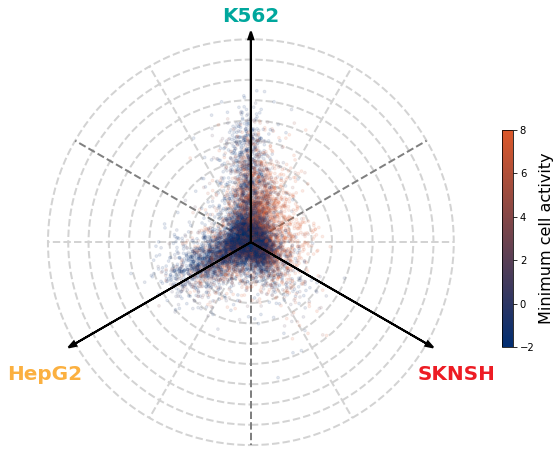

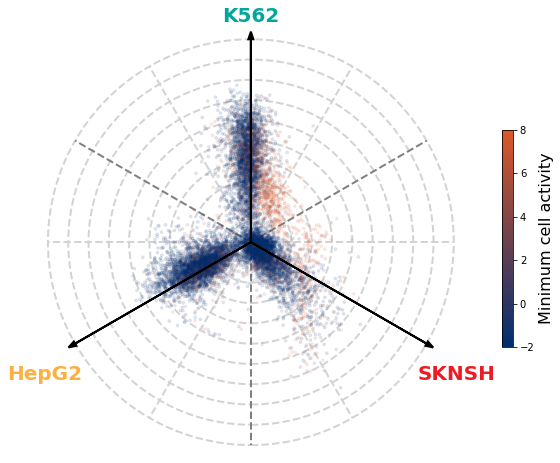

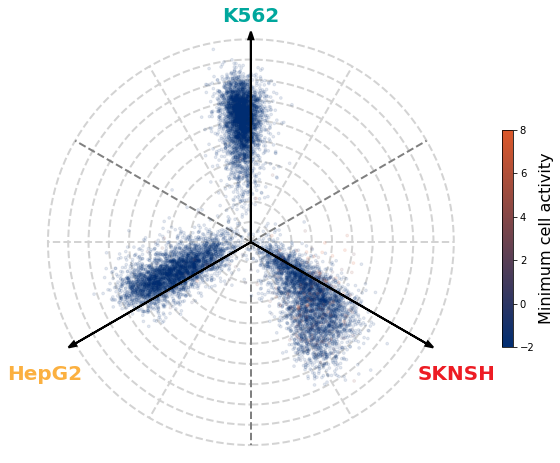

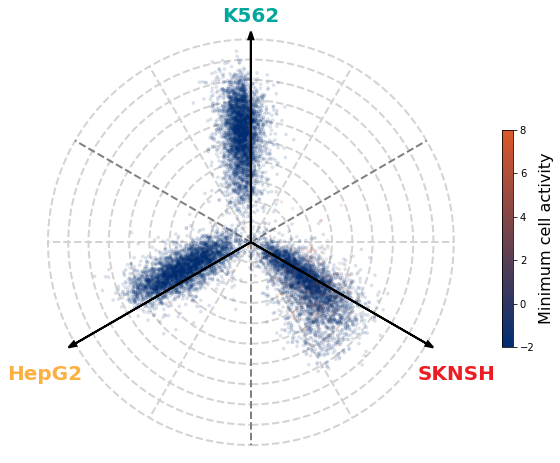

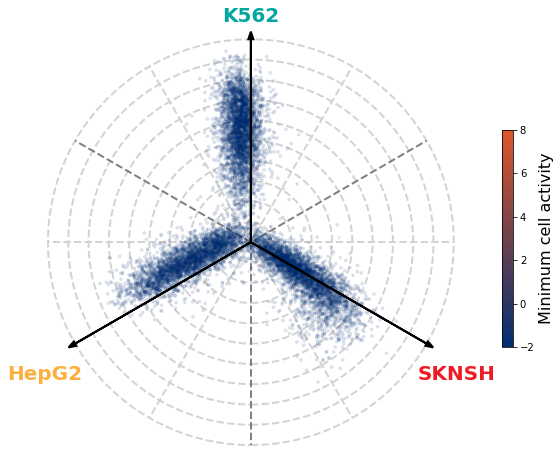

In [26]:
cell_types = ['K562', 'HepG2', 'SKNSH']
l2fc_columns = [f'{cell_type}_signal' for cell_type in cell_types]

# methods = ['DHS', 'gs', 'fsp', 'sa', 'al', 'hmc', 'fsp_uc', 'sa_uc', 'al_uc', 'sa_rep']
# titles = ['DHS', 'Genome Scan', 'Fast SeqProp', 'Simulated Annealing', 'AdaLead', 'HMC',
#           'UC Fast SeqProp', 'UC Simulated Annealing', 'UC AdaLead', 'REP Simulated Annealing']
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
titles = ['DHS', 'Genome Scan', 'Fast SeqProp', 'SimAnneal', 'AdaLead']
for method, title in zip(methods, titles):
    point_array = round_0_boda2_df[round_0_boda2_df['method'] == method][l2fc_columns].to_numpy()
    fig, ax = propeller_dot_plot(point_array,
                                 R=10,
                                 axis_labels=cell_types,
                                 title=None, #title,
                                 colorbar_label='Minimum cell activity',
                                 soft_guideline_color='lightgrey',
                                 mid_guideline_color='grey',
                                 rasterized=True,
                                 min_color=-2,
                                 max_color=8,
                                 soft_guideline_width=2,
                                 mid_guideline_width=2,
                                 dot_size=30,
                                 colorbar=True, #False,
                                 cmap=custom_cmap #mpl.cm.get_cmap('coolwarm') #my_cm #mpl.cm.get_cmap('viridis_r')
                                )
    flat_title = '_'.join(title.split(' '))
    savepath = f'./figures/propeller_dot__{flat_title}_v5.pdf'
    
    plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
    plt.show()

DHS


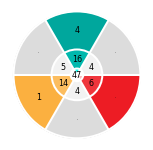

Genome Scan


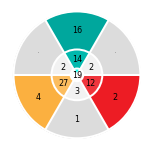

Fast SeqProp


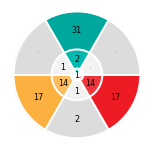

SimAnneal


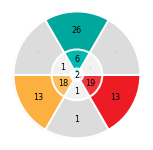

AdaLead


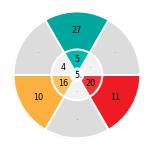

In [27]:
cell_types = ['K562', 'HepG2', 'SKNSH']
l2fc_columns = [f'{cell_type}_signal' for cell_type in cell_types]

# methods = ['DHS', 'gs', 'fsp', 'sa', 'al', 'hmc', 'fsp_uc', 'sa_uc', 'al_uc', 'sa_rep']
# titles = ['DHS', 'Genome Scan', 'Fast SeqProp', 'Simulated Annealing', 'AdaLead', 'HMC',
#           'UC Fast SeqProp', 'UC Simulated Annealing', 'UC AdaLead', 'REP Simulated Annealing']
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
titles = ['DHS', 'Genome Scan', 'Fast SeqProp', 'SimAnneal', 'AdaLead']
for method, title in zip(methods, titles):
    point_array = round_0_boda2_df[round_0_boda2_df['method'] == method][l2fc_columns].to_numpy()
    print(title)
    fig, ax = propeller_pie_plot(point_array,
#                                    title=title,
#                                    axis_labels=cell_types,
                                   pie_colors=['#00A79D', '#FBB040', '#ED1C24'],
                                   R=10,
                                   figsize=(2.5,2.5), #(10, 10) (2.5,2.5)
                                   label_padding = 1.5,
                                   axis_label_fontsize=20,
                                   title_fontsize=30,
                                   title_y = 1.1,
                                   sep_line_color = 'white',
                                   sep_line_width = 2,
                                   sep_line_style = '-',
                                   mid_section_color = 'gainsboro',
                                   lighting_amount = [1.1, 1.5],
                                   pct_fontsize_factor = 20, #14
                                   integer_pcts = True, #False,
                                )
    flat_title = '_'.join(title.split(' '))
    savepath = f'./figures/propeller_pie__{flat_title}_v5.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
    plt.show()

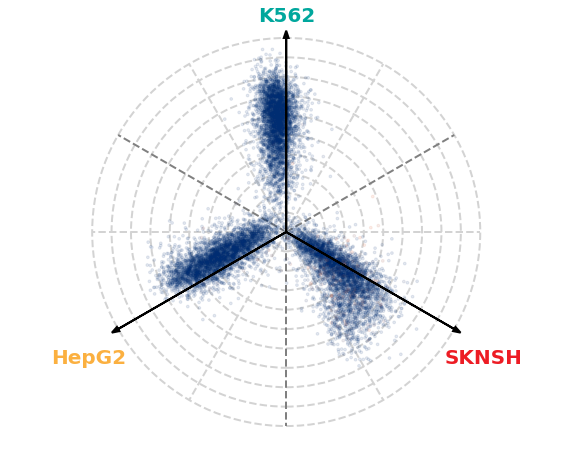

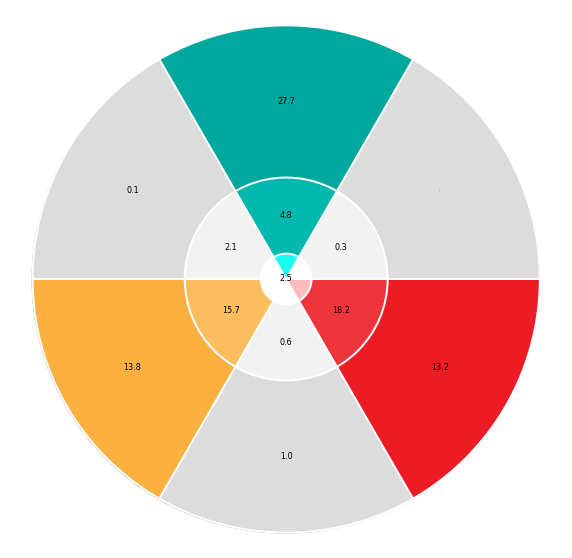

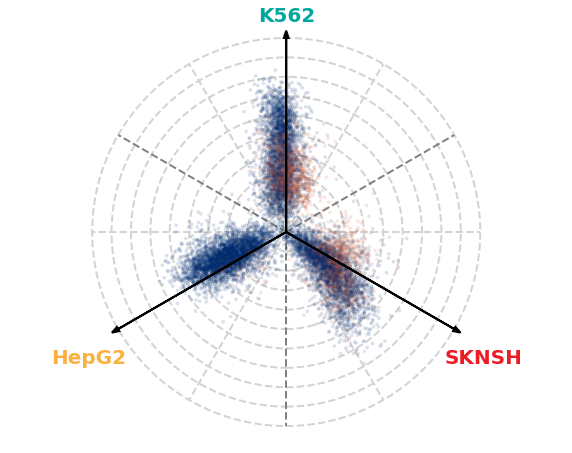

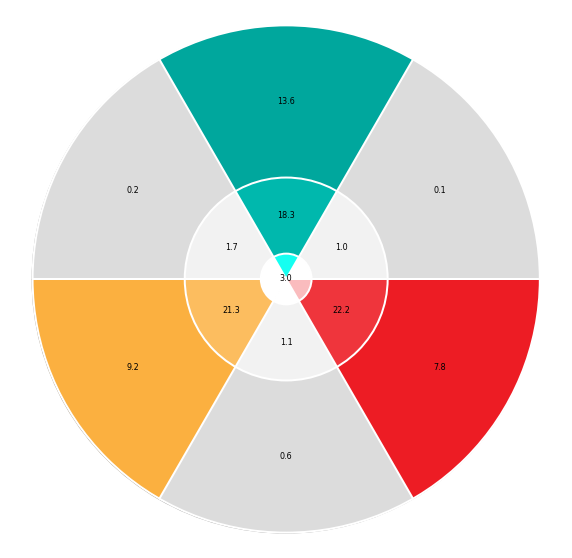

In [17]:
#------ Unpenalized synthetics -------   
point_array = round_0_boda2_df[round_0_boda2_df['method'].isin(['sa', 'al', 'fsp']) & (round_0_boda2_df['round'] == 0)].reset_index(drop=True)
point_array = point_array.sample(12000, random_state=123)[l2fc_columns].to_numpy()
#point_array = point_array[l2fc_columns]#.to_numpy()
fig, ax = propeller_dot_plot(point_array,
                             R=10,
                             axis_labels=cell_types,
                             title=None, #title,
                             colorbar_label='Minimum cell activity',
                             soft_guideline_color='lightgrey',
                             mid_guideline_color='grey',
                             rasterized=True,
                             min_color=-2,
                             max_color=8,
                             soft_guideline_width=2,
                             mid_guideline_width=2,
                             dot_size=30,
                             colorbar=False,
                             cmap=custom_cmap #mpl.cm.get_cmap('coolwarm') #my_cm #mpl.cm.get_cmap('viridis_r')
                            )
#flat_title = '_'.join(title.split(' '))
savepath = f'./figures/propeller_dot__synthetics_sample_v5.pdf'
#plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
plt.show()

fig, ax = propeller_pie_plot(point_array,
#                                    title=title,
#                                    axis_labels=cell_types,
                               pie_colors=['#00A79D', '#FBB040', '#ED1C24'],
                               R=10,
                               figsize=(10, 10), #(2.5,2.5),
                               label_padding = 1.5,
                               axis_label_fontsize=20,
                               title_fontsize=30,
                               title_y = 1.1,
                               sep_line_color = 'white',
                               sep_line_width = 2,
                               sep_line_style = '-',
                               mid_section_color = 'gainsboro',
                               lighting_amount = [1.1, 1.5],
                               pct_fontsize_factor = 20, #14
                               integer_pcts = False,
                            )
#flat_title = '_'.join(title.split(' '))
savepath = f'./figures/propeller_pie__synthetics_sample_v5.pdf'
#plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
plt.show()
    
#------ Penalized synthetics -------   
point_array = boda2_df[boda2_df['method'].isin(['fsp']) & (boda2_df['round'] != 0)].reset_index(drop=True)
point_array = point_array.sample(12000, random_state=123)[l2fc_columns].to_numpy()
#point_array = point_array[l2fc_columns].to_numpy()
fig, ax = propeller_dot_plot(point_array,
                             R=10,
                             axis_labels=cell_types,
                             title=None, #title,
                             colorbar_label='Minimum cell activity',
                             soft_guideline_color='lightgrey',
                             mid_guideline_color='grey',
                             rasterized=True,
                             min_color=-2,
                             max_color=8,
                             soft_guideline_width=2,
                             mid_guideline_width=2,
                             dot_size=30,
                             colorbar=False,
                             cmap=custom_cmap #mpl.cm.get_cmap('coolwarm') #my_cm #mpl.cm.get_cmap('viridis_r')
                            )
#flat_title = '_'.join(title.split(' '))
savepath = f'./figures/propeller_dot__penalized_synthetics_sample_v5.pdf'
#plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
plt.show()

fig, ax = propeller_pie_plot(point_array,
#                                    title=title,
#                                    axis_labels=cell_types,
                               pie_colors=['#00A79D', '#FBB040', '#ED1C24'],
                               R=10,
                               figsize=(10, 10), #(2.5,2.5),
                               label_padding = 1.5,
                               axis_label_fontsize=20,
                               title_fontsize=30,
                               title_y = 1.1,
                               sep_line_color = 'white',
                               sep_line_width = 2,
                               sep_line_style = '-',
                               mid_section_color = 'gainsboro',
                               lighting_amount = [1.1, 1.5],
                               pct_fontsize_factor = 20, #14
                               integer_pcts = False,
                            )
#flat_title = '_'.join(title.split(' '))
savepath = f'./figures/propeller_pie__penalized_synthetics_sample_v5.pdf'
#plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
plt.show()

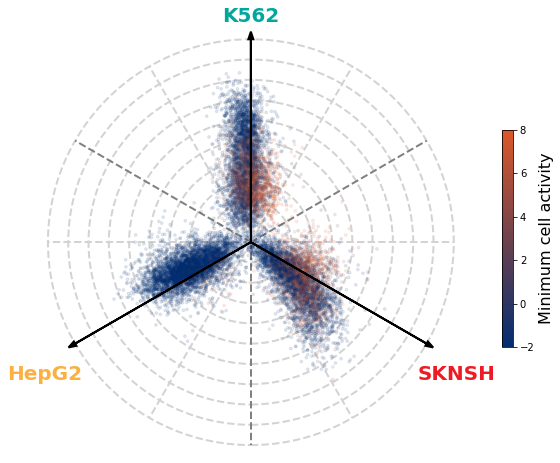

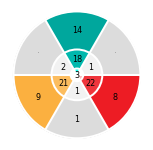

In [22]:
#------ Penalized synthetics -------   
point_array = boda2_df[boda2_df['method'].isin(['fsp']) & (boda2_df['round'] != 0)].reset_index(drop=True)
point_array = point_array[l2fc_columns].to_numpy()
fig, ax = propeller_dot_plot(point_array,
                             R=10,
                             axis_labels=cell_types,
                             title=None, #title,
                             colorbar_label='Minimum cell activity',
                             soft_guideline_color='lightgrey',
                             mid_guideline_color='grey',
                             rasterized=True,
                             min_color=-2,
                             max_color=8,
                             soft_guideline_width=2,
                             mid_guideline_width=2,
                             dot_size=30,
                             cmap=custom_cmap #mpl.cm.get_cmap('coolwarm') #my_cm #mpl.cm.get_cmap('viridis_r')
                            )
#flat_title = '_'.join(title.split(' '))
savepath = f'./figures/propeller_dot__penalized_synthetics_all_v5.pdf'
plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
plt.show()

fig, ax = propeller_pie_plot(point_array,
#                                    title=title,
#                                    axis_labels=cell_types,
                               pie_colors=['#00A79D', '#FBB040', '#ED1C24'],
                               R=10,
                               figsize=(2.5,2.5), #(10,10),
                               label_padding = 1.5,
                               axis_label_fontsize=20,
                               title_fontsize=30,
                               title_y = 1.1,
                               sep_line_color = 'white',
                               sep_line_width = 2,
                               sep_line_style = '-',
                               mid_section_color = 'gainsboro',
                               lighting_amount = [1.1, 1.5],
                               pct_fontsize_factor = 20, #14
                               integer_pcts = True #False,
                            )
#flat_title = '_'.join(title.split(' '))
savepath = f'./figures/propeller_pie__penalized_synthetics_all_v5.pdf'
plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
plt.show()

# GTEx

In [6]:
ukbb_gtex_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/MPRA_ALL_no_cutoffs_v2.txt', sep=" ", low_memory=False)

In [8]:
ukbb_gtex_df[ukbb_gtex_df['IDs'] == '5:138775301:C:T:R:wC']

,HepG2_mean,HepG2_std,ID_count,IDs,K562_mean,K562_std,OL,OL_count,SKNSH_mean,SKNSH_std,chr,class,ctrl_mean_hepg2,ctrl_mean_k562,ctrl_mean_sknsh,data_project,exp_mean_hepg2,exp_mean_k562,exp_mean_sknsh,lfcSE_hepg2,lfcSE_k562,lfcSE_sknsh,nt_sequence,padj_hepg2,padj_k562,padj_sknsh,pvalue_hepg2,pvalue_k562,pvalue_sknsh
705343,5.60631,NaN,1,5:138775301:C:T:R:wC,6.384894,NaN,41,1.0,7.176057,NaN,5,GTEx,591.775993,430.236486,431.138219,GTEX,28813.393327,35945.481662,62339.25282,0.067051,0.079184,0.103176,GAGCGCGGGGCACGCTGGTCATTGTAGTCCAGTCCATATGAGCTCC...,0.0,0.0,0.0,0.0,0.0,0.0


In [551]:
quality_filter = (ukbb_gtex_df[['lfcSE_k562', 'lfcSE_hepg2', 'lfcSE_sknsh']].max(axis=1) <= 1.0)
ukbb_gtex_df = ukbb_gtex_df[quality_filter].reset_index(drop=True)

In [554]:
gtex_df = ukbb_gtex_df[ukbb_gtex_df['data_project'] == 'GTEX'].reset_index(drop=True)
gtex_df['max_pvalue'] =  gtex_df[['pvalue_k562', 'pvalue_hepg2', 'pvalue_sknsh']].max(axis=1)
#gtex_df.sort_values('max_pvalue', inplace=True)

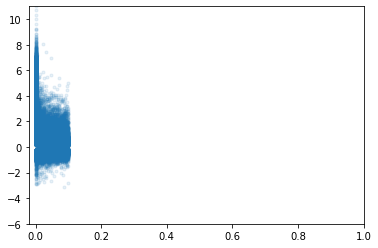

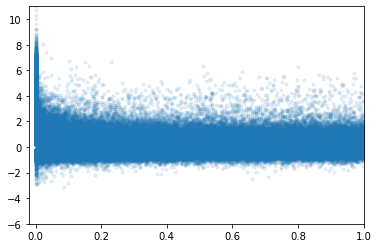

In [569]:
subset_df = gtex_df[gtex_df['max_pvalue'] <= 1e-1]

plt.scatter(data=subset_df, x='max_pvalue', y='HepG2_mean', marker='.', alpha=0.1)
plt.xlim(-0.02,1)
plt.ylim(-6,11)
plt.show()

plt.scatter(data=gtex_df, x='max_pvalue', y='HepG2_mean', marker='.', alpha=0.1)
plt.xlim(-0.02,1)
plt.ylim(-6,11)
plt.show()

In [ ]:
cell_types = ['K562', 'HepG2', 'SKNSH']
l2fc_columns = [f'{cell_type}_mean' for cell_type in cell_types]

gtex_sample_points = gtex_df.sample(12000, random_state=123)[activity_columns].to_numpy()
gtex_pval_subset_points = subset_df.sample(12000, random_state=1234)[activity_columns].to_numpy()
all_gtex_points = gtex_df[activity_columns].to_numpy()

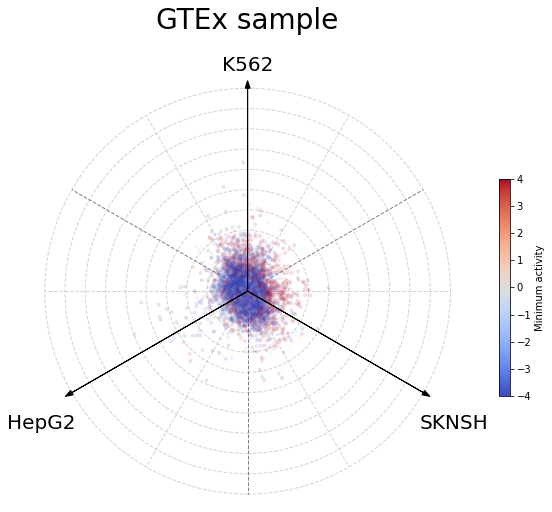

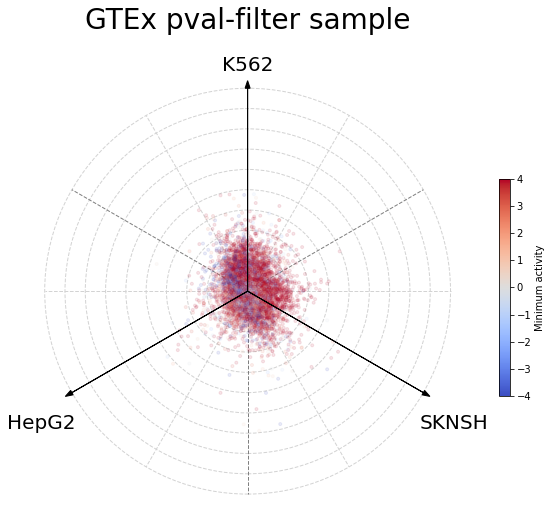

In [617]:
point_arrays = [gtex_sample_points, gtex_pval_subset_points]
titles = ['GTEx sample', 'GTEx pval-filter sample']
for point_array, title in zip(point_arrays, titles):
    fig, ax = propeller_dot_plot(point_array,
                                 R=10,
                                 axis_labels=cell_types,
                                 title=title,
                                 colorbar_label='Minimum activity',
                                 rasterized=True,
                                )
    flat_title = '_'.join(title.split(' '))
    savepath = f'./figures/propeller_dot__{flat_title}.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
    plt.show()

GTEx sample


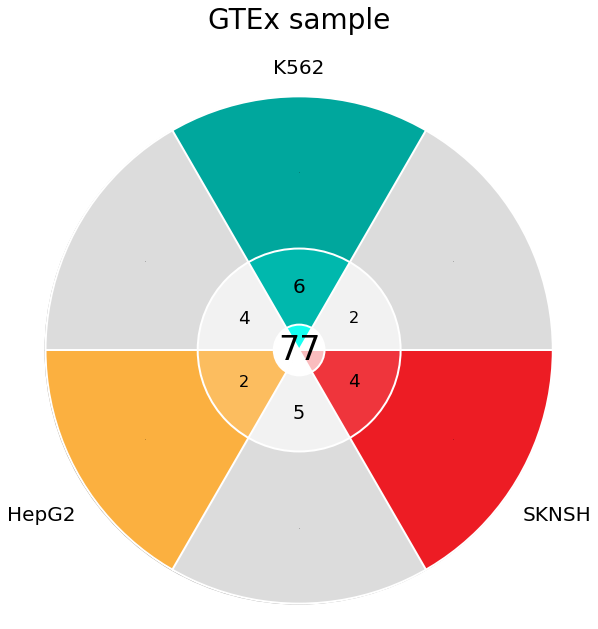

GTEx pval-filter sample


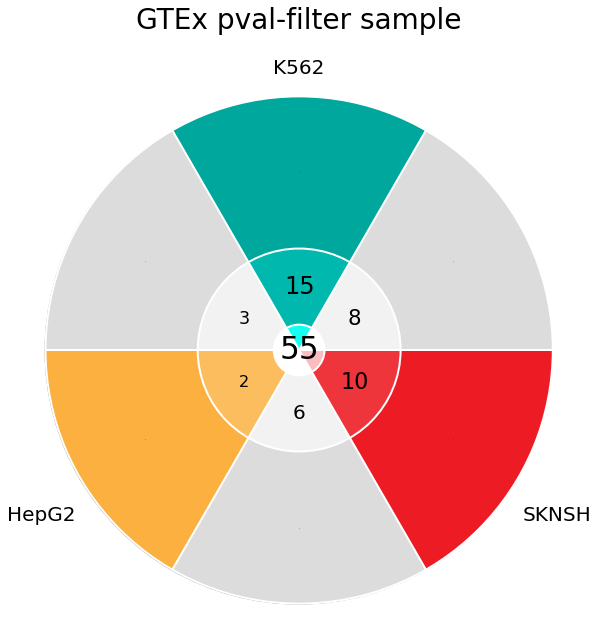

GTEx all


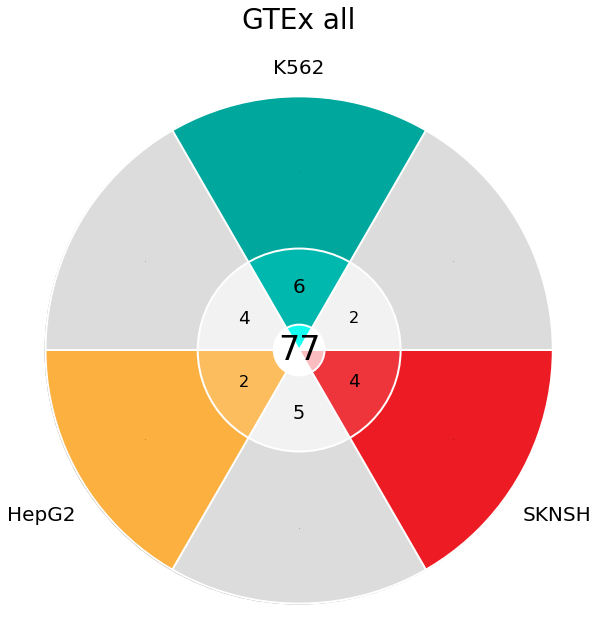

In [592]:
#gtex_sample_points = gtex_df.sample(12000, random_state=123)[activity_columns].to_numpy()

point_arrays = [gtex_sample_points, gtex_pval_subset_points, all_gtex_points]
titles = ['GTEx sample', 'GTEx pval-filter sample', 'GTEx all']
for point_array, title in zip(point_arrays, titles):
    print(title)
    fig, ax = propeller_pie_plot(point_array,
                       title=title,
                       axis_labels=cell_types,
                       pie_colors=['#00A79D', '#FBB040', '#ED1C24'],
                       R=10,
                       figsize=(10,10),
                       label_padding = 1.5,
                       axis_label_fontsize=20,
                       title_fontsize=28,
                       title_y = 1.08,
                       sep_line_color = 'white',
                       sep_line_width = 2,
                       sep_line_style = '-',
                       mid_section_color = 'gainsboro',
                       lighting_amount = [1.1, 1.5],
                       pct_fontsize_factor = 14,
                       integer_pcts = True)
    flat_title = '_'.join(title.split(' '))
    savepath = f'./figures/propeller_pie__{flat_title}.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
    plt.show()

# UKBB & BODA 0

In [489]:
boda0_df = ukbb_gtex_df[ukbb_gtex_df['data_project'] == 'BODA'].reset_index(drop=True)
ukbb_df = ukbb_gtex_df[ukbb_gtex_df['data_project'] == 'UKBB'].reset_index(drop=True)

boda0_nat = boda0_df[boda0_df['chr'] != 'synth'][['K562_mean', 'HepG2_mean', 'SKNSH_mean']].to_numpy()
boda0_syn = boda0_df[boda0_df['chr'] == 'synth'][['K562_mean', 'HepG2_mean', 'SKNSH_mean']].to_numpy()

ukbb_point = ukbb_df[['K562_mean', 'HepG2_mean', 'SKNSH_mean']].to_numpy()
ukbb_points_subset = ukbb_df.sample(120)[['K562_mean', 'HepG2_mean', 'SKNSH_mean']].to_numpy()

# Empty propeller plot

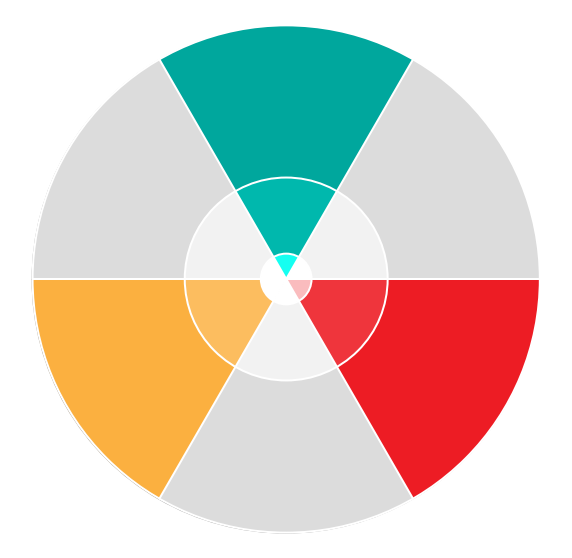

In [54]:
 inner_circle_radii=[1,4,10]
title=None
axis_labels=None#cell_types
pie_colors=['#00A79D', '#FBB040', '#ED1C24']
R=10
figsize=(10,10)
label_padding = 1.5
axis_label_fontsize=20
title_fontsize=28
title_y = 1.08
sep_line_color = 'white'
sep_line_width = 2
sep_line_style = '-'
mid_section_color = 'gainsboro'
lighting_amount = [1.1, 1.5]
pct_fontsize_factor = 14
integer_pcts = True

    
#--------------------- Construct figure ----------------------------
#inner_circle_radii = pcts_df['radius'].tolist()
x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
floor_R =  np.floor(R)
floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))

#--- Get gradual colors for inner circles
pie_colors = [pie_colors[0], mid_section_color, pie_colors[1], mid_section_color, pie_colors[2], mid_section_color]
all_pie_colors = [pie_colors]
for i in range(len(inner_circle_radii) - 1):
    all_pie_colors.append([adjust_lightness(c, amount=lighting_amount[i]) for c in all_pie_colors[i]])

#--- Begin figure
fig, ax = plt.subplots(figsize=(10, 10))

#--- Background pie
sizes = 6*[100/6]
for radius_idx, radius in enumerate(reversed(inner_circle_radii)):
    ax.pie(sizes, colors=all_pie_colors[radius_idx], textprops={'fontsize': 20}, # labels=labels,
        shadow=True, startangle=60, radius=radius)

for radius in inner_circle_radii:
    ax.add_patch(plt.Circle((0,0), radius, color=sep_line_color, fill=False, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1))

ax.axis('equal') 

#--- Line guides
plt.plot([0, floor_R], [0, 0], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)
plt.plot([0, -floor_R], [0, 0], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)

plt.plot([0, -floor_y1], [0, floor_x1], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)
plt.plot([0, floor_y1], [0, floor_x1], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)

plt.plot([0, -floor_y1], [0, -floor_x1], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)
plt.plot([0, floor_y1], [0, -floor_x1], color=sep_line_color, linestyle=sep_line_style, linewidth=sep_line_width, zorder=1)

if axis_labels:
    plt.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize)
    plt.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize)
    plt.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize)

savepath = f'./figures/propeller_pie__empty.pdf'
plt.savefig(savepath, format='pdf', transparent=True, dpi=300)
plt.show()

# Motif topics (custom plot)

In [19]:
# topic_weights = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_topic_modeling/topic_weighted_overmax.txt',
#                             sep="\t", low_memory=False)
topic_weights = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_topic_modeling_min8/program_signal.tsv',
                            sep="\t", low_memory=False)
topic_weights_pred = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_topic_modeling_min8/program_pred.tsv',
                            sep="\t", low_memory=False)

topic_weights = topic_weights.T
topic_weights_pred = topic_weights_pred.T

topic_weights = topic_weights.drop('Unnamed: 0', axis=0)
topic_weights_pred = topic_weights_pred.drop('Unnamed: 0', axis=0)

In [73]:
from matplotlib.colors import to_rgba

hepg2_1 = '#993404'
hepg2_2 = '#d95f0e'
hepg2_3 = '#fe9929'

k562_1 = '#253494'
k562_2 = '#41b6c4'

sknsh_1 = '#D500FF' # '#FF00D0' # 
sknsh_2 = '#FF0004'
sknsh_3 = '#FF5CB0' # #fddaec

extra_1 = '#fed9a6'
extra_2 = '#ccebc5'
extra_3 = '#ffffcc'
extra_4 = '#e5d8bd'
extra_5 = '#decbe4'

blank   = '#f2f2f2'

#topic_colors =  [ mpl.colors.to_rgba(x) for x in [hepg2_1,sknsh_3,extra_1,sknsh_1,extra_2,k562_1,extra_3,extra_4,sknsh_2,k562_2,extra_5,hepg2_2,hepg2_3] ]

topic_colors =  sns.color_palette('Paired', 12)

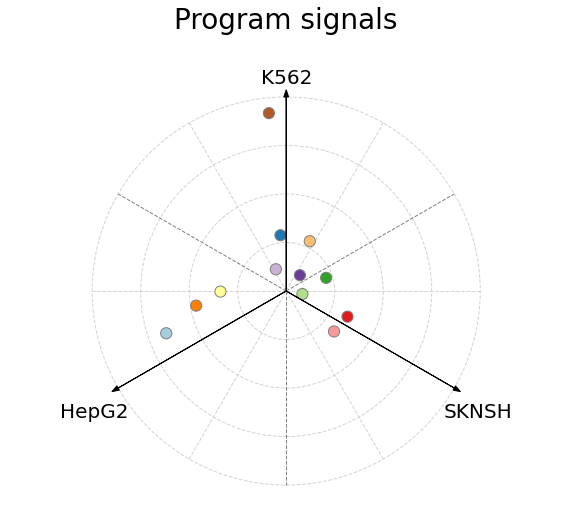

In [74]:
point_array = topic_weights.to_numpy().T #topic_weights.to_numpy()[1:, :].astype(float)

cell_types = ['K562', 'HepG2', 'SKNSH']

title='Program signals'
axis_labels=cell_types
R=4
figsize=(10,8)
min_color=-1,
max_color=1,
cmap=mpl.cm.coolwarm
axis_color='black'
soft_guideline_color='lightgrey'
mid_guideline_color='grey'
soft_guideline_stlye='--'
mid_guideline_stlye='--'
soft_guideline_width=1
mid_guideline_width=1
label_padding = 0.5
axis_arrow_head_scale=0.025
axis_label_fontsize=20
title_fontsize=28
title_y = 1.08
colorbar_label=None
colorbar_aspect=20
colorbar_shrink=0.5
dot_alpha=1
rasterized=True
dot_size=500,
color_list=topic_colors
colorbar=False
inner_radii = [1, 2, 3, 4]
dot_edgecolor = 'gray'
    
x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
floor_R =  np.floor(R)
floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))

fig, ax = plt.subplots(figsize=figsize)
plt.axis('equal')

#--- Get coloring for minimum
if color_list is None:
    #min_color, max_color = point_array.min(axis=1).min(), point_array.min(axis=1).max()
    color_values = point_array.min(axis=1)
    norm = mpl.colors.Normalize(vmin=min_color, vmax=max_color)
    color_list = cmap(color_values)

#--- Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#---Remove ticks
plt.xticks([])
plt.yticks([])

#--- Line guides
plt.plot( [0, 0], [0, -floor_R], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
plt.plot([0, floor_x1], [0, floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
plt.plot([0, -floor_x1], [0,  floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)

plt.plot([0, floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
plt.plot([0, -floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

plt.plot([0, -floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
plt.plot([0, floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

plt.plot([0, -floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
plt.plot([0, floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

#--- Circles

if not inner_radii:
    inner_radii = np.arange(1, floor_R+1)   
for radius in inner_radii:
    ax.add_patch(plt.Circle((0,0), radius, color=soft_guideline_color, fill=False,
                            linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1))

#--- Main axes
plt.arrow(0, 0, 0, R, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
plt.arrow(0, 0, x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
plt.arrow(0, 0, -x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)

if axis_labels:
    plt.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize)
    plt.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize)
    plt.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize)

#--- Plot points
shifted_points = point_array - point_array.min(axis=1)[:, None]

Xs = []
Ys = []
for row in range(shifted_points.shape[0]):
    point = shifted_points[row, :]
    min_dim = point.argmin()
    max_dim = point.argmax()

    mid_dim = [0, 1, 2]
    mid_dim.remove(min_dim)
    mid_dim.remove(max_dim)
    mid_dim = mid_dim[0]

    temp_r = point[max_dim]
    temp_theta_shift = 60 * point[mid_dim] / point[max_dim]
    if max_dim == 0:
        if mid_dim == 1:
            temp_theta = 90 + temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 90 - temp_theta_shift
    elif max_dim == 1:
        if mid_dim == 0:
            temp_theta = 210 - temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 210 + temp_theta_shift
    elif max_dim == 2:
        if mid_dim == 1:
            temp_theta = 330 - temp_theta_shift
        elif mid_dim == 0:
            temp_theta = -30 + temp_theta_shift

    temp_x = temp_r * np.cos(np.deg2rad(temp_theta))
    temp_y = temp_r * np.sin(np.deg2rad(temp_theta))        
    Xs.append(temp_x)
    Ys.append(temp_y)

plt.scatter(Xs, Ys, color=color_list, alpha=dot_alpha, marker='.', rasterized=rasterized, zorder=2, s=dot_size, edgecolors=dot_edgecolor)  
if title:
    plt.title(title, fontsize=title_fontsize, y=title_y)

#--- Plot colorbar
if colorbar:
    cax, cbar_kwds = mpl.colorbar.make_axes(ax, location = 'right',
                              fraction=0.15, shrink=colorbar_shrink, aspect=colorbar_aspect)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    if colorbar_label:
        cb.set_label(colorbar_label)
           
plt.show()

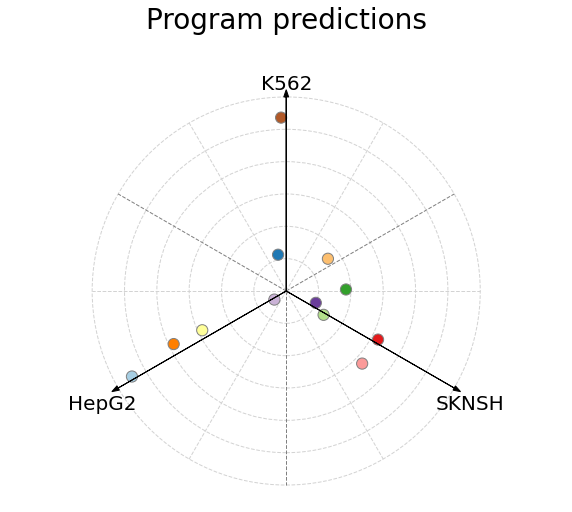

In [75]:
point_array = topic_weights_pred.to_numpy().T #topic_weights.to_numpy()[1:, :].astype(float)

topic_colors =  sns.color_palette('Paired', point_array.shape[0])
cell_types = ['K562', 'HepG2', 'SKNSH']

title=''
axis_labels=cell_types
R=6
figsize=(10,8)
min_color=-1,
max_color=1,
cmap=mpl.cm.coolwarm
axis_color='black'
soft_guideline_color='lightgrey'
mid_guideline_color='grey'
soft_guideline_stlye='--'
mid_guideline_stlye='--'
soft_guideline_width=1
mid_guideline_width=1
label_padding = 0.5
axis_arrow_head_scale=0.025
axis_label_fontsize=20
title_fontsize=28
title_y = 1.08
colorbar_label=None
colorbar_aspect=20
colorbar_shrink=0.5
dot_alpha=1
rasterized=True
dot_size=500,
color_list=topic_colors
colorbar=False
inner_radii = [1, 2, 3, 4, 5, 6]
dot_edgecolor = 'gray'
    
x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
floor_R =  np.floor(R)
floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))

fig, ax = plt.subplots(figsize=figsize)
plt.axis('equal')

#--- Get coloring for minimum
if color_list is None:
    #min_color, max_color = point_array.min(axis=1).min(), point_array.min(axis=1).max()
    color_values = point_array.min(axis=1)
    norm = mpl.colors.Normalize(vmin=min_color, vmax=max_color)
    color_list = cmap(color_values)

#--- Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#---Remove ticks
plt.xticks([])
plt.yticks([])

#--- Line guides
plt.plot( [0, 0], [0, -floor_R], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
plt.plot([0, floor_x1], [0, floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
plt.plot([0, -floor_x1], [0,  floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)

plt.plot([0, floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
plt.plot([0, -floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

plt.plot([0, -floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
plt.plot([0, floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

plt.plot([0, -floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
plt.plot([0, floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

#--- Circles

if not inner_radii:
    inner_radii = np.arange(1, floor_R+1)   
for radius in inner_radii:
    ax.add_patch(plt.Circle((0,0), radius, color=soft_guideline_color, fill=False,
                            linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1))

#--- Main axes
plt.arrow(0, 0, 0, R, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
plt.arrow(0, 0, x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
plt.arrow(0, 0, -x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)

if axis_labels:
    plt.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize)
    plt.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize)
    plt.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize)

#--- Plot points
shifted_points = point_array - point_array.min(axis=1)[:, None]

Xs = []
Ys = []
for row in range(shifted_points.shape[0]):
    point = shifted_points[row, :]
    min_dim = point.argmin()
    max_dim = point.argmax()

    mid_dim = [0, 1, 2]
    mid_dim.remove(min_dim)
    mid_dim.remove(max_dim)
    mid_dim = mid_dim[0]

    temp_r = point[max_dim]
    temp_theta_shift = 60 * point[mid_dim] / point[max_dim]
    if max_dim == 0:
        if mid_dim == 1:
            temp_theta = 90 + temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 90 - temp_theta_shift
    elif max_dim == 1:
        if mid_dim == 0:
            temp_theta = 210 - temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 210 + temp_theta_shift
    elif max_dim == 2:
        if mid_dim == 1:
            temp_theta = 330 - temp_theta_shift
        elif mid_dim == 0:
            temp_theta = -30 + temp_theta_shift

    temp_x = temp_r * np.cos(np.deg2rad(temp_theta))
    temp_y = temp_r * np.sin(np.deg2rad(temp_theta))        
    Xs.append(temp_x)
    Ys.append(temp_y)

plt.scatter(Xs, Ys, color=color_list, alpha=dot_alpha, marker='.', rasterized=rasterized, zorder=2, s=dot_size, edgecolors=dot_edgecolor)  
if title:
    plt.title(title, fontsize=title_fontsize, y=title_y)

#--- Plot colorbar
if colorbar:
    cax, cbar_kwds = mpl.colorbar.make_axes(ax, location = 'right',
                              fraction=0.15, shrink=colorbar_shrink, aspect=colorbar_aspect)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    if colorbar_label:
        cb.set_label(colorbar_label)
           
plt.show()

# BODA STREME TFs contributions

In [7]:
boda2_streme_tfs = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_global_analysis/streme_TFs_ultimate_merge.txt', sep=" ", low_memory=False)

In [8]:
boda2_streme_tfs.loc[0, 'contribution_HepG2'] = 0.5 * boda2_streme_tfs.loc[0, 'contribution_HepG2']

In [9]:
(np.array([len(x) for x in boda2_streme_tfs['ultimate_id'].str.split().tolist()]) == 1).sum() / len(boda2_streme_tfs)

0.53125

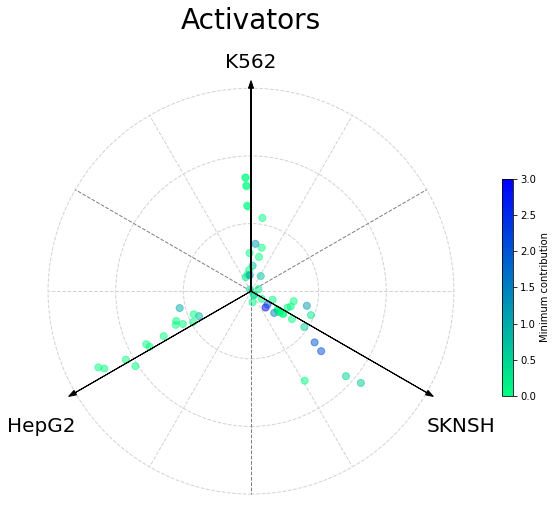

In [11]:
cell_types = ['K562', 'HepG2', 'SKNSH']

pos_filter = (boda2_streme_tfs[['contribution_K562', 'contribution_HepG2', 'contribution_SKNSH']].mean(axis=1) >= 0)
point_array = boda2_streme_tfs[pos_filter][['contribution_K562', 'contribution_HepG2', 'contribution_SKNSH']].to_numpy()

title='Activators'
axis_labels=cell_types
R=3
figsize=(10,8)
min_color=0
max_color=3
cmap=mpl.cm.get_cmap('winter_r') #mpl.cm.cool #Blues
axis_color='black'
soft_guideline_color='lightgrey'
mid_guideline_color='grey'
soft_guideline_stlye='--'
mid_guideline_stlye='--'
soft_guideline_width=1
mid_guideline_width=1
label_padding = 0.5
axis_arrow_head_scale=0.025
axis_label_fontsize=20
title_fontsize=28
title_y = 1.08
colorbar_label='Minimum contribution' #'Up-regulation contribution'
colorbar_aspect=20
colorbar_shrink=0.5
dot_alpha=0.5
rasterized=True
dot_size=200
color_list=None
colorbar=True
inner_radii = None#[0.75, 2]
dot_edgecolor = 'gray'
    
x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
floor_R =  np.floor(R)
floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))

fig, ax = plt.subplots(figsize=figsize)
plt.axis('equal')

#--- Get coloring for minimum
if color_list is None:
    #min_color, max_color = point_array.min(axis=1).min(), point_array.min(axis=1).max()
    color_values = point_array.min(axis=1) #point_array.max(axis=1) #point_array.min(axis=1)
    norm = mpl.colors.Normalize(vmin=min_color, vmax=max_color)
    color_list = cmap(color_values)

#--- Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#---Remove ticks
plt.xticks([])
plt.yticks([])

#--- Line guides
ax.plot( [0, 0], [0, -floor_R], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
ax.plot([0, floor_x1], [0, floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
ax.plot([0, -floor_x1], [0,  floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)

ax.plot([0, floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, -floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

ax.plot([0, -floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

ax.plot([0, -floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

#--- Circles

if not inner_radii:
    inner_radii = np.arange(1, floor_R+1)   
for radius in inner_radii:
    ax.add_patch(plt.Circle((0,0), radius, color=soft_guideline_color, fill=False,
                            linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1))

#--- Main axes
ax.arrow(0, 0, 0, R, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
ax.arrow(0, 0, x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
ax.arrow(0, 0, -x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)

if axis_labels:
    ax.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize)
    ax.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize)
    ax.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize)

#--- Plot points
shifted_points = point_array - point_array.min(axis=1)[:, None]

Xs = []
Ys = []
for row in range(shifted_points.shape[0]):
    point = shifted_points[row, :]
    min_dim = point.argmin()
    max_dim = point.argmax()

    mid_dim = [0, 1, 2]
    mid_dim.remove(min_dim)
    mid_dim.remove(max_dim)
    mid_dim = mid_dim[0]

    temp_r = point[max_dim]
    temp_theta_shift = 60 * point[mid_dim] / point[max_dim]
    if max_dim == 0:
        if mid_dim == 1:
            temp_theta = 90 + temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 90 - temp_theta_shift
    elif max_dim == 1:
        if mid_dim == 0:
            temp_theta = 210 - temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 210 + temp_theta_shift
    elif max_dim == 2:
        if mid_dim == 1:
            temp_theta = 330 - temp_theta_shift
        elif mid_dim == 0:
            temp_theta = -30 + temp_theta_shift

    temp_x = temp_r * np.cos(np.deg2rad(temp_theta))
    temp_y = temp_r * np.sin(np.deg2rad(temp_theta))        
    Xs.append(temp_x)
    Ys.append(temp_y)

ax.scatter(Xs, Ys, color=color_list, alpha=dot_alpha, marker='.', rasterized=rasterized, zorder=2, s=dot_size)  
if title:
    plt.title(title, fontsize=title_fontsize, y=title_y)

#--- Plot colorbar
if colorbar:
    cax, cbar_kwds = mpl.colorbar.make_axes(ax, location = 'right',
                              fraction=0.15, shrink=colorbar_shrink, aspect=colorbar_aspect)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    if colorbar_label:
        cb.set_label(colorbar_label)

savepath = f'./figures/motif_propeller_plot__activators.pdf'
plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
plt.show()

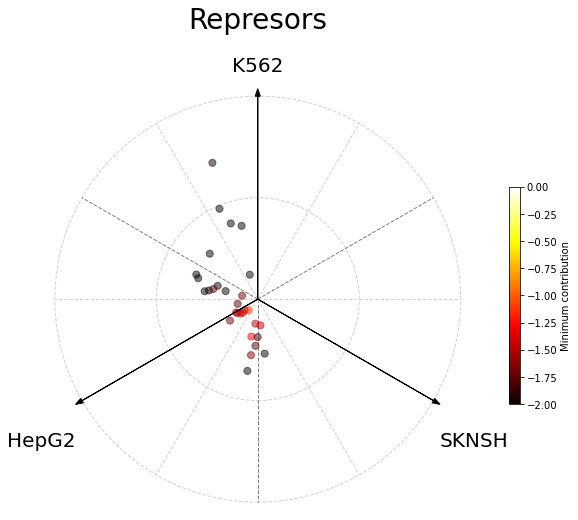

In [12]:
point_array = boda2_streme_tfs[~pos_filter][['contribution_K562', 'contribution_HepG2', 'contribution_SKNSH']].to_numpy()
point_array = -point_array
point_array = point_array[~(np.isnan(point_array).prod(axis=1).astype(bool)), :]

title='Represors'
axis_labels=cell_types
R=1.5
figsize=(10,8)
min_color=0
max_color=2
cmap=mpl.cm.get_cmap('hot') # mpl.cm.get_cmap('Reds_r')  mpl.cm.Reds
axis_color='black'
soft_guideline_color='lightgrey'
mid_guideline_color='grey'
soft_guideline_stlye='--'
mid_guideline_stlye='--'
soft_guideline_width=1
mid_guideline_width=1
label_padding = 0.3
axis_arrow_head_scale=0.025
axis_label_fontsize=20
title_fontsize=28
title_y = 1.1
colorbar_label='Minimum contribution'#'Down-regulation contribution'
colorbar_aspect=20
colorbar_shrink=0.5
dot_alpha=0.5
rasterized=True
dot_size=200
color_list=None
colorbar=True
inner_radii = [0.75, 1.5]
dot_edgecolor = 'gray'
    
x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
if inner_radii is not None:
    floor_R = inner_radii[-1]
else:
    floor_R = np.floor(R)
floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))

fig, ax = plt.subplots(figsize=figsize)
plt.axis('equal')

#--- Get coloring for minimum
if color_list is None:
    #min_color, max_color = point_array.min(axis=1).min(), point_array.min(axis=1).max()
    color_values = point_array.min(axis=1) #point_array.max(axis=1) #point_array.min(axis=1)
    norm = mpl.colors.Normalize(vmin=-max_color, vmax=min_color)
    color_list = cmap(color_values)

#--- Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#---Remove ticks
plt.xticks([])
plt.yticks([])

#--- Line guides
ax.plot( [0, 0], [0, -floor_R], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
ax.plot([0, floor_x1], [0, floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
ax.plot([0, -floor_x1], [0,  floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)

ax.plot([0, floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, -floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

ax.plot([0, -floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

ax.plot([0, -floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
ax.plot([0, floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

#--- Circles

if not inner_radii:
    inner_radii = np.arange(1, floor_R+1)   
for radius in inner_radii:
    ax.add_patch(plt.Circle((0,0), radius, color=soft_guideline_color, fill=False,
                            linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1))

#--- Main axes
ax.arrow(0, 0, 0, R, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
ax.arrow(0, 0, x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
ax.arrow(0, 0, -x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)

if axis_labels:
    ax.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize)
    ax.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize)
    ax.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize)

#--- Plot points
shifted_points = point_array - point_array.min(axis=1)[:, None]

Xs = []
Ys = []
for row in range(shifted_points.shape[0]):
    point = shifted_points[row, :]
    min_dim = point.argmin()
    max_dim = point.argmax()

    mid_dim = [0, 1, 2]
    mid_dim.remove(min_dim)
    mid_dim.remove(max_dim)
    mid_dim = mid_dim[0]

    temp_r = point[max_dim]
    temp_theta_shift = 60 * point[mid_dim] / point[max_dim]
    if max_dim == 0:
        if mid_dim == 1:
            temp_theta = 90 + temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 90 - temp_theta_shift
    elif max_dim == 1:
        if mid_dim == 0:
            temp_theta = 210 - temp_theta_shift
        elif mid_dim == 2:
            temp_theta = 210 + temp_theta_shift
    elif max_dim == 2:
        if mid_dim == 1:
            temp_theta = 330 - temp_theta_shift
        elif mid_dim == 0:
            temp_theta = -30 + temp_theta_shift

    temp_x = temp_r * np.cos(np.deg2rad(temp_theta))
    temp_y = temp_r * np.sin(np.deg2rad(temp_theta))        
    Xs.append(temp_x)
    Ys.append(temp_y)

ax.scatter(Xs, Ys, color=color_list, alpha=dot_alpha, marker='.', rasterized=rasterized, zorder=2, s=dot_size)  
if title:
    plt.title(title, fontsize=title_fontsize, y=title_y)

#--- Plot colorbar
if colorbar:
    cax, cbar_kwds = mpl.colorbar.make_axes(ax, location = 'right',
                              fraction=0.15, shrink=colorbar_shrink, aspect=colorbar_aspect)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    if colorbar_label:
        cb.set_label(colorbar_label)

savepath = f'./figures/motif_propeller_plot__repressors.pdf'
plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
plt.show()

In [70]:
point_array.shape

(30, 3)

In [72]:
30/96

0.3125

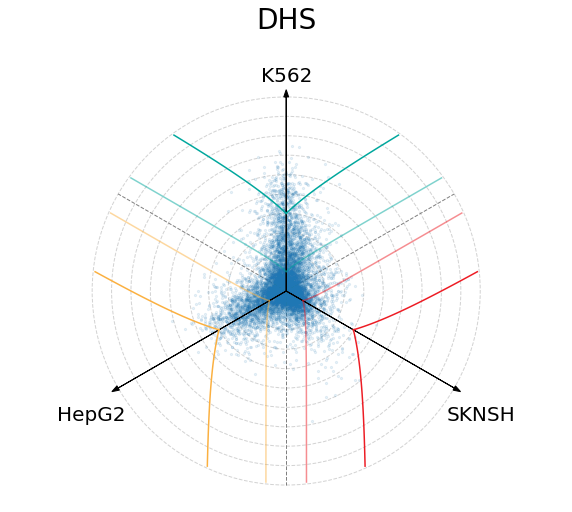

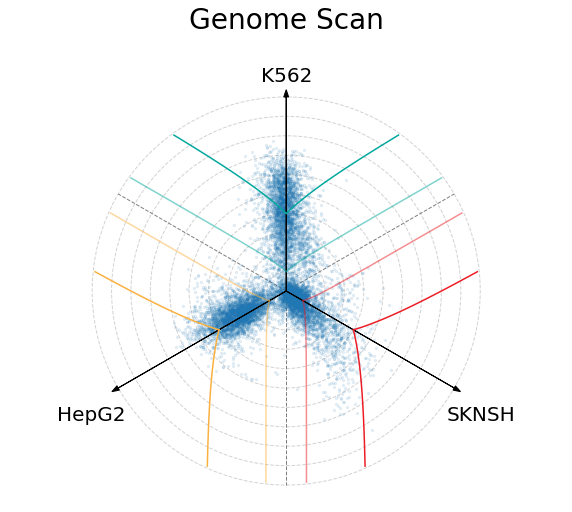

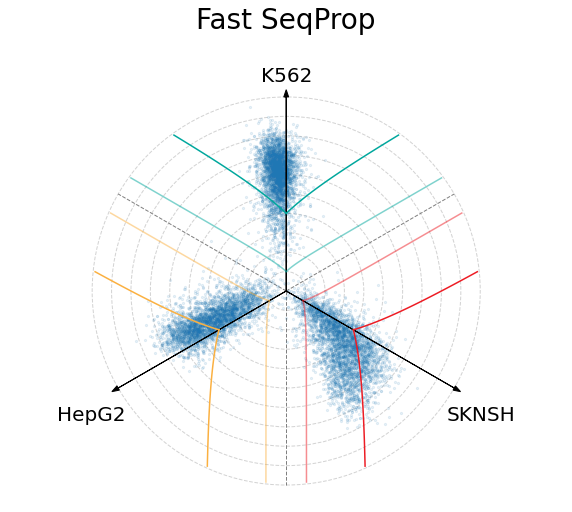

In [54]:
l2fc_columns = [f'{cell_type}_signal' for cell_type in cell_types]
methods = ['DHS', 'gs', 'fsp']
titles = ['DHS', 'Genome Scan', 'Fast SeqProp']
cell_types = ['K562', 'HepG2', 'SKNSH']

for method, title in zip(methods, titles):
    point_array = round_0_boda2_df[round_0_boda2_df['method'] == method][l2fc_columns].to_numpy()

    #title='Activators'
    axis_labels=cell_types
    R=10
    figsize=(10,8)
    min_color=0
    max_color=3
    cmap=mpl.cm.get_cmap('winter_r') #mpl.cm.cool #Blues
    axis_color='black'
    soft_guideline_color='lightgrey'
    mid_guideline_color='grey'
    soft_guideline_stlye='--'
    mid_guideline_stlye='--'
    soft_guideline_width=1
    mid_guideline_width=1
    label_padding = 1.4
    axis_arrow_head_scale=0.025
    axis_label_fontsize=20
    title_fontsize=28
    title_y = 1.08
    colorbar_label='Minimum contribution' #'Up-regulation contribution'
    colorbar_aspect=20
    colorbar_shrink=0.5
    dot_alpha=0.1
    rasterized=True
    dot_size=20
    color_list=None
    colorbar=True
    inner_radii = None#[0.75, 2]
    dot_edgecolor = 'gray'
`
    x1, y1 = R*np.cos(np.deg2rad(30)), R*np.sin(np.deg2rad(30))
    floor_R =  np.floor(R)
    floor_x1, floor_y1 = floor_R*np.cos(np.deg2rad(30)), floor_R*np.sin(np.deg2rad(30))

    fig, ax = plt.subplots(figsize=figsize)
    plt.axis('equal')

    # #--- Get coloring for minimum
    # if color_list is None:
    #     #min_color, max_color = point_array.min(axis=1).min(), point_array.min(axis=1).max()
    #     color_values = point_array.min(axis=1) #point_array.max(axis=1) #point_array.min(axis=1)
    #     norm = mpl.colors.Normalize(vmin=min_color, vmax=max_color)
    #     color_list = cmap(color_values)

    #--- Remove frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #---Remove ticks
    plt.xticks([])
    plt.yticks([])

    #--- Line guides
    ax.plot( [0, 0], [0, -floor_R], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
    ax.plot([0, floor_x1], [0, floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)
    ax.plot([0, -floor_x1], [0,  floor_y1], color=mid_guideline_color, linestyle=mid_guideline_stlye, linewidth=mid_guideline_width, zorder=1)

    # ax.plot([0, floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
    # ax.plot([0, -floor_R], [0, 0], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

    # ax.plot([0, -floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
    # ax.plot([0, floor_y1], [0, floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

    # ax.plot([0, -floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)
    # ax.plot([0, floor_y1], [0, -floor_x1], color=soft_guideline_color, linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1)

    #--- Circles

    if not inner_radii:
        inner_radii = np.arange(1, floor_R+1)   
    for radius in inner_radii:
        ax.add_patch(plt.Circle((0,0), radius, color=soft_guideline_color, fill=False,
                                linestyle=soft_guideline_stlye, linewidth=soft_guideline_width, zorder=1))

    #--- Main axes
    ax.arrow(0, 0, 0, R, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
    ax.arrow(0, 0, x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)
    ax.arrow(0, 0, -x1, -y1, color=axis_color, shape='full', head_width=axis_arrow_head_scale * R, zorder=2)

    if axis_labels:
        ax.text(0, R + 0.75*label_padding, axis_labels[0], ha='center', va='center', fontsize=axis_label_fontsize)
        ax.text(-x1 - label_padding, -y1 - label_padding, axis_labels[1], ha='center', va='center', fontsize=axis_label_fontsize)
        ax.text(x1 + label_padding, -y1 - label_padding, axis_labels[2], ha='center', va='center', fontsize=axis_label_fontsize)

    #--- Plot points
    shifted_points = point_array - point_array.min(axis=1)[:, None]

    Xs = []
    Ys = []
    for row in range(shifted_points.shape[0]):
        point = shifted_points[row, :]
        min_dim = point.argmin()
        max_dim = point.argmax()

        mid_dim = [0, 1, 2]
        mid_dim.remove(min_dim)
        mid_dim.remove(max_dim)
        mid_dim = mid_dim[0]

        temp_r = point[max_dim]
        temp_theta_shift = 60 * point[mid_dim] / point[max_dim]
        if max_dim == 0:
            if mid_dim == 1:
                temp_theta = 90 + temp_theta_shift
            elif mid_dim == 2:
                temp_theta = 90 - temp_theta_shift
        elif max_dim == 1:
            if mid_dim == 0:
                temp_theta = 210 - temp_theta_shift
            elif mid_dim == 2:
                temp_theta = 210 + temp_theta_shift
        elif max_dim == 2:
            if mid_dim == 1:
                temp_theta = 330 - temp_theta_shift
            elif mid_dim == 0:
                temp_theta = -30 + temp_theta_shift

        temp_x = temp_r * np.cos(np.deg2rad(temp_theta))
        temp_y = temp_r * np.sin(np.deg2rad(temp_theta))        
        Xs.append(temp_x)
        Ys.append(temp_y)

    ax.scatter(Xs, Ys, color=color_list, alpha=dot_alpha, marker='.', rasterized=rasterized, zorder=2, s=dot_size)  
    if title:
        plt.title(title, fontsize=title_fontsize, y=title_y)

    # #--- Plot colorbar
    # if colorbar:
    #     cax, cbar_kwds = mpl.colorbar.make_axes(ax, location = 'right',
    #                               fraction=0.15, shrink=colorbar_shrink, aspect=colorbar_aspect)
    #     cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    #     if colorbar_label:
    #         cb.set_label(colorbar_label)

    angle_colors = {90: '#00A79D', 210:'#FBB040', 330:'#ED1C24'}

    light_adjust = 1
    for overmax_threshold in [4, 1]:
        for ref_angle in [90, 210, 330]:
            right_overmax_Xs = []
            right_overmax_Ys = []
            left_overmax_Xs = []
            left_overmax_Ys = []
            for r in np.arange(overmax_threshold, R, 0.1):
                theta_shift = 60 * (r - overmax_threshold) / r
                right_theta = ref_angle - theta_shift
                left_theta = ref_angle + theta_shift

                right_overmax_Xs.append( r * np.cos(np.deg2rad(right_theta)) )
                right_overmax_Ys.append( r * np.sin(np.deg2rad(right_theta)) )

                left_overmax_Xs.append( r * np.cos(np.deg2rad(left_theta)) )
                left_overmax_Ys.append( r * np.sin(np.deg2rad(left_theta)) )

            color = angle_colors[ref_angle]
            #color = adjust_lightness(color, amount=light_adjust)
            plt.plot(right_overmax_Xs, right_overmax_Ys, color=color, alpha=light_adjust)
            plt.plot(left_overmax_Xs, left_overmax_Ys, color=color, alpha=light_adjust)
        light_adjust = 0.5 * light_adjust

    plt.show()

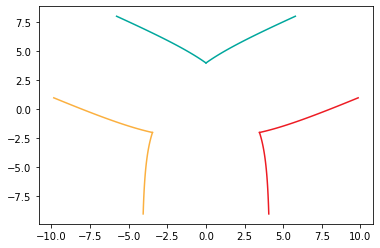

In [24]:
angle_colors = {90: '#00A79D', 210:'#FBB040', 330:'#ED1C24'}

overmax_threshold = 4

for ref_angle in [90, 210, 330]:
    right_overmax_Xs = []
    right_overmax_Ys = []
    left_overmax_Xs = []
    left_overmax_Ys = []
    for r in np.arange(overmax_threshold, R, 0.1):
        theta_shift = 60 * (r - overmax_threshold) / r
        right_theta = ref_angle - theta_shift
        left_theta = ref_angle + theta_shift

        right_overmax_Xs.append( r * np.cos(np.deg2rad(right_theta)) )
        right_overmax_Ys.append( r * np.sin(np.deg2rad(right_theta)) )

        left_overmax_Xs.append( r * np.cos(np.deg2rad(left_theta)) )
        left_overmax_Ys.append( r * np.sin(np.deg2rad(left_theta)) )

    plt.plot(right_overmax_Xs, right_overmax_Ys, color=angle_colors[ref_angle])
    plt.plot(left_overmax_Xs, left_overmax_Ys, color=angle_colors[ref_angle])
plt.show()

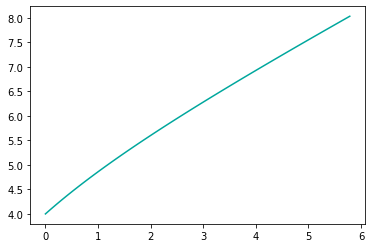

In [22]:
plt.plot(right_overmax_Xs, right_overmax_Ys, color=angle_colors[ref_angle])

### Counting sequences that flip from their target cell type

In [29]:
row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
row_filter_2 = (boda2_df['method'] == 'fsp')

precise_library_df = boda2_df[row_filter_1 | row_filter_2].reset_index(drop=True)

In [92]:
radial_threshold = 1
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
for method in methods:
    print(f'--- {method} ---')
    temp_df = precise_library_df[(precise_library_df['method'] == method) & (precise_library_df['round'] == 0)]

    max_columns = temp_df[l2fc_columns].idxmax(axis=1).tolist()
    min_columns = temp_df[l2fc_columns].idxmin(axis=1).tolist()

    maxies = temp_df[l2fc_columns].max(axis=1).to_numpy()
    minies = temp_df[l2fc_columns].min(axis=1).to_numpy()

    med_columns = []
    for min_column, max_column in zip(min_columns, max_columns):
        columns = ['K562_signal', 'HepG2_signal', 'SKNSH_signal']
        columns.remove(min_column)
        columns.remove(max_column)
        med_columns.append(columns[0])

    medies = []
    for i, med_column in enumerate(med_columns):
        medies.append(temp_df.iloc[i][med_column].item())
    medies = np.array(medies)

    angle_passing_idxs = (((medies - minies) / (maxies - minies)) < 0.5)
    radial_passing_idxs = (maxies - minies) > radial_threshold
    passing_idxs = np.where(angle_passing_idxs * radial_passing_idxs)[0]
    print(len(passing_idxs) / len(temp_df))

    temp_df_2 = temp_df.iloc[passing_idxs].reset_index(drop=True)
    num_passing_seqs = len(temp_df_2[temp_df_2['target_cell'] != temp_df_2['signal_max_cell']])
    pct_passing_seqs = num_passing_seqs / len(temp_df)
    print(num_passing_seqs, pct_passing_seqs)
    print('')
    
print(f'--- FSP penalized ---')
temp_df = precise_library_df[(precise_library_df['method'] == 'fsp') & (precise_library_df['round'] > 0)]

max_columns = temp_df[l2fc_columns].idxmax(axis=1).tolist()
min_columns = temp_df[l2fc_columns].idxmin(axis=1).tolist()

maxies = temp_df[l2fc_columns].max(axis=1).to_numpy()
minies = temp_df[l2fc_columns].min(axis=1).to_numpy()

med_columns = []
for min_column, max_column in zip(min_columns, max_columns):
    columns = ['K562_signal', 'HepG2_signal', 'SKNSH_signal']
    columns.remove(min_column)
    columns.remove(max_column)
    med_columns.append(columns[0])

medies = []
for i, med_column in enumerate(med_columns):
    medies.append(temp_df.iloc[i][med_column].item())
medies = np.array(medies)

angle_passing_idxs = (((medies - minies) / (maxies - minies)) < 0.5)
radial_passing_idxs = (maxies - minies) > radial_threshold
passing_idxs = np.where(angle_passing_idxs * radial_passing_idxs)[0]
print(len(passing_idxs) / len(temp_df))

temp_df_2 = temp_df.iloc[passing_idxs].reset_index(drop=True)
num_passing_seqs = len(temp_df_2[temp_df_2['target_cell'] != temp_df_2['signal_max_cell']])
pct_passing_seqs = num_passing_seqs / len(temp_df)
print(num_passing_seqs, pct_passing_seqs)
print('')   

--- DHS ---
0.40588071089606403
565 0.05257281101702801

--- gs ---
0.7351247600767754
39 0.003564573622155196

--- fsp ---
0.9440719830628087
0 0.0

--- sa ---
0.9518826580806725
5 0.0004471871925588051

--- al ---
0.8980263157894737
12 0.0010964912280701754

--- FSP penalized ---
0.9239636136379418
4 0.00027775848899381985



In [93]:
radial_threshold = 4
methods = ['DHS', 'gs', 'fsp', 'sa', 'al']
for method in methods:
    print(f'--- {method} ---')
    temp_df = precise_library_df[(precise_library_df['method'] == method) & (precise_library_df['round'] == 0)]

    max_columns = temp_df[l2fc_columns].idxmax(axis=1).tolist()
    min_columns = temp_df[l2fc_columns].idxmin(axis=1).tolist()

    maxies = temp_df[l2fc_columns].max(axis=1).to_numpy()
    minies = temp_df[l2fc_columns].min(axis=1).to_numpy()

    med_columns = []
    for min_column, max_column in zip(min_columns, max_columns):
        columns = ['K562_signal', 'HepG2_signal', 'SKNSH_signal']
        columns.remove(min_column)
        columns.remove(max_column)
        med_columns.append(columns[0])

    medies = []
    for i, med_column in enumerate(med_columns):
        medies.append(temp_df.iloc[i][med_column].item())
    medies = np.array(medies)

    angle_passing_idxs = (((medies - minies) / (maxies - minies)) < 0.5)
    radial_passing_idxs = (maxies - minies) > radial_threshold
    passing_idxs = np.where(angle_passing_idxs * radial_passing_idxs)[0]
    print(len(passing_idxs) / len(temp_df))

    temp_df_2 = temp_df.iloc[passing_idxs].reset_index(drop=True)
    num_passing_seqs = len(temp_df_2[temp_df_2['target_cell'] != temp_df_2['signal_max_cell']])
    pct_passing_seqs = num_passing_seqs / len(temp_df)
    print(num_passing_seqs, pct_passing_seqs)
    print('')
    
print(f'--- FSP penalized ---')
temp_df = precise_library_df[(precise_library_df['method'] == 'fsp') & (precise_library_df['round'] > 0)]

max_columns = temp_df[l2fc_columns].idxmax(axis=1).tolist()
min_columns = temp_df[l2fc_columns].idxmin(axis=1).tolist()

maxies = temp_df[l2fc_columns].max(axis=1).to_numpy()
minies = temp_df[l2fc_columns].min(axis=1).to_numpy()

med_columns = []
for min_column, max_column in zip(min_columns, max_columns):
    columns = ['K562_signal', 'HepG2_signal', 'SKNSH_signal']
    columns.remove(min_column)
    columns.remove(max_column)
    med_columns.append(columns[0])

medies = []
for i, med_column in enumerate(med_columns):
    medies.append(temp_df.iloc[i][med_column].item())
medies = np.array(medies)

angle_passing_idxs = (((medies - minies) / (maxies - minies)) < 0.5)
radial_passing_idxs = (maxies - minies) > radial_threshold
passing_idxs = np.where(angle_passing_idxs * radial_passing_idxs)[0]
print(len(passing_idxs) / len(temp_df))

temp_df_2 = temp_df.iloc[passing_idxs].reset_index(drop=True)
num_passing_seqs = len(temp_df_2[temp_df_2['target_cell'] != temp_df_2['signal_max_cell']])
pct_passing_seqs = num_passing_seqs / len(temp_df)
print(num_passing_seqs, pct_passing_seqs)
print('')  

--- DHS ---
0.047548152972922676
15 0.0013957383455848143

--- gs ---
0.2147884105657618
0 0.0

--- fsp ---
0.6450247000705717
0 0.0

--- sa ---
0.5195420803148197
0 0.0

--- al ---
0.47578581871345027
1 9.137426900584795e-05

--- FSP penalized ---
0.3082424831608916
0 0.0



# Clean table for paper

In [5]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v3.txt', sep=" ", low_memory=False)

In [153]:
row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
row_filter_2 = (boda2_df['method'] == 'fsp') | boda2_df['method'].isna()

precise_library_df = boda2_df[row_filter_1 | row_filter_2].reset_index(drop=True)

In [154]:
precise_library_df = precise_library_df.drop(columns=['K562_pred',
                   'HepG2_pred', 'SKNSH_pred','pred_max_cell', 'signal_max_cell', 'target_cell_lfc', 'max_non_target_cell', 'max_non_target_lfc',
                   'min_non_target_cell', 'min_non_target_lfc', 'mean_non_target_lfc',
                   'OverMean', 'contrib_K562', 'contrib_HepG2', 'contrib_SKNSH', 'project',
                   'K562_ctrl_mean', 'HepG2_ctrl_mean', 'SKNSH_ctrl_mean',
                   'K562_exp_mean', 'HepG2_exp_mean','SKNSH_exp_mean',
                                                     ])

In [155]:
fsp_row_filter = precise_library_df['method'] == 'fsp'
track_info = [a[1] for a in precise_library_df.loc[fsp_row_filter]['ID'].str.split('__').tolist() ]
precise_library_df.loc[fsp_row_filter, 'track_ID'] = track_info

In [156]:
methods = ['sa', 'al', 'fsp', 'DHS', 'gs']
ranames = ['Simulated_Annealing', 'AdaLead', 'FastSeqProp', 'DHS_natural', 'Malinois_natural']

for method, rename in zip(methods, ranames):
    temp_row_filter = precise_library_df['method'] == method
    precise_library_df.loc[temp_row_filter, 'origin'] = rename
    
temp_row_filter = precise_library_df['method'].isna()
precise_library_df.loc[temp_row_filter, 'origin'] = 'control'

precise_library_df = precise_library_df.drop(columns=['method'])

In [157]:
precise_library_df.rename(columns={'K562_signal':'K562_l2fc', 'HepG2_signal':'HepG2_l2fc', 'SKNSH_signal':'SKNSH_l2fc',
                                   'K562_pred_aggreg':'K562_prediction', 'HepG2_pred_aggreg':'HepG2_prediction', 'SKNSH_pred_aggreg':'SKNSH_prediction',
                                   'OverMax':'MinGap',
                                  },
                          inplace=True,
                         )

In [161]:
precise_library_df = precise_library_df[['ID', 'sequence', 'origin', 'target_cell', 'round', 'track_ID', 
                   'K562_l2fc', 'HepG2_l2fc', 'SKNSH_l2fc', 'MinGap',
                   'K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE',            
                   'K562_prediction', 'HepG2_prediction', 'SKNSH_prediction',
                   ] 
       ]

In [163]:
precise_library_df.to_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/CODA_paper_library.txt', sep='\t', index=None)

In [3]:
aver = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/CODA_paper_library.txt', sep='\t', low_memory=False)
aver

,ID,sequence,origin,target_cell,round,track_ID,K562_l2fc,HepG2_l2fc,SKNSH_l2fc,MinGap,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_prediction,HepG2_prediction,SKNSH_prediction
0,20211207_63610__124703__1::sa__hepg2__0,TCGAAACAGGTATACCGCCAGCAATCCAATCTCTACCGGTGTACAC...,Simulated_Annealing,hepg2,0,NaN,-0.311911,2.196081,-0.917639,2.507992,0.172967,0.283926,0.348235,-1.470296,5.797530,-1.390143
1,20211207_63610__124703__4::sa__hepg2__0,GCTAAGGTCCTTATTGAATTTTGGTTAATCATTAACTACCCGTCAT...,Simulated_Annealing,hepg2,0,NaN,-1.110302,0.880661,-1.097117,1.977779,0.379151,0.224763,0.387839,-0.945908,5.258021,-0.792220
2,20211207_63610__124703__5::sa__hepg2__0,TGGTCCATTCCTGGGAATTTGCCGCCTGTACCTGCAAGGTTATACA...,Simulated_Annealing,hepg2,0,NaN,-0.545083,2.169025,-1.135171,2.714108,0.466518,0.328841,0.580014,-1.018296,5.671950,-0.911035
3,20211207_63610__124703__12::sa__hepg2__0,TCGGGAGATGTCAACACCTGTTGAGCTATTATGCCCTAGCCTGGTT...,Simulated_Annealing,hepg2,0,NaN,-0.769610,2.042634,-0.703300,2.745934,0.591487,0.265328,2.890125,-1.059856,5.068971,-1.219801
4,20211207_63610__124703__15::sa__hepg2__0,GACTTTGAACTCTGGACAGCAGAACAAATCACGGGAACCCTGTCAT...,Simulated_Annealing,hepg2,0,NaN,-0.654328,2.037279,-1.243780,2.691607,0.247053,0.267308,0.247788,-0.842918,6.010541,-0.930583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77152,ORF54316:2538:1300-1500,CTCGGAGTTCAAGAAAATCATCTCACACGGCCGTCTCAGACCCTTC...,control,NaN,0,NaN,-0.315267,0.591628,0.068697,NaN,0.384919,0.363142,0.275408,-0.158865,1.282273,-0.275202
77153,ORF53130:1455:400-600,GCAATCCTACCCAGACAGATGCAGACAGCGACCTGGTGGGGGATGT...,control,NaN,0,NaN,-0.134821,-0.359782,-0.022281,NaN,0.178379,0.261176,0.200300,-0.247987,-0.644892,-0.367910
77154,ORF55877:2391:1900-2100,CCTATGCTGCCTCCTATGCCCTTGTCATCATTGCCATTTTTGAGCT...,control,NaN,0,NaN,0.646673,0.489900,0.462366,NaN,0.259927,0.190735,0.111966,0.524327,0.483457,0.248783
77155,ORF52950:2193:400-600,AGCCACAACAAAACAGCCAGTTAATGTGGAAACAAGGTCGACAACT...,control,NaN,0,NaN,-0.061676,-0.014411,0.239693,NaN,0.171760,0.199712,0.166026,0.085746,0.563376,0.668541


In [4]:
aver[aver['ID'] == '20211207_63610__124703__622::sa__hepg2__0']

,ID,sequence,origin,target_cell,round,track_ID,K562_l2fc,HepG2_l2fc,SKNSH_l2fc,MinGap,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_prediction,HepG2_prediction,SKNSH_prediction
249,20211207_63610__124703__622::sa__hepg2__0,CAATCGACAGTCTCATCCAAAGTTTATTGTAGGTTAATCATTAACC...,Simulated_Annealing,hepg2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.668537,5.738205,-0.725472


In [6]:
boda2_df[boda2_df['ID'] == '20211207_63610__124703__622::sa__hepg2__0']

,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH
3142,20211207_63610__124703__622::sa__hepg2__0,CAATCGACAGTCTCATCCAAAGTTTATTGTAGGTTAATCATTAACC...,BODA:hepg2,sa,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.792776,6.194629,-0.816073,-0.668537,5.738205,-0.725472,hepg2,NaN,hepg2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[ 2.66374107e-02 7.08695650e-02 4.34919260e-...,[ 1.35065511e-01 2.70356983e-01 2.28956625e-...,[-0.0020314658 0.070775054 0.05252402 0....


DHS_natural            384
Malinois_natural       309
FastSeqProp            110
AdaLead                 77
Simulated_Annealing     65
control                 19
Name: origin, dtype: int64


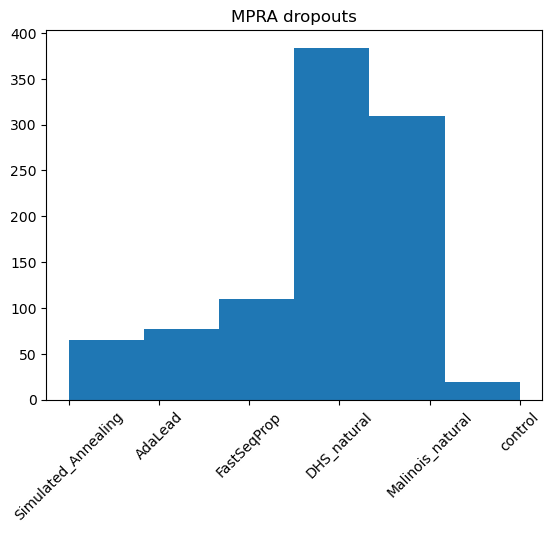

In [21]:
#aver_filter = boda2_df['K562_signal'].isna() & boda2_df['HepG2_signal'].isna() & boda2_df['SKNSH_signal'].isna()
aver_filter = aver['K562_l2fc'].isna() & aver['HepG2_l2fc'].isna() & aver['SKNSH_l2fc'].isna()

print(aver.loc[aver_filter]['origin'].value_counts())

aver.loc[aver_filter]['origin'].hist(bins=6, grid=False)
plt.xticks(rotation=45)
plt.title('MPRA dropouts')
plt.show()

In [23]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred.txt', sep=" ", low_memory=False)

aver_filter = boda2_df['K562_signal'].isna() & boda2_df['HepG2_signal'].isna() & boda2_df['SKNSH_signal'].isna()

boda2_df.loc[aver_filter]['method'].value_counts()

DHS            384
genome_scan    309
sa             232
fsp            110
al              91
hmc             28
al_uc            2
Name: method, dtype: int64

### Checking seqs MinGap > 1

In [24]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v3.txt', sep=" ", low_memory=False)

quality_filter = (boda2_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
boda2_df = boda2_df[quality_filter].reset_index(drop=True)

In [25]:
row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
row_filter_2 = (boda2_df['method'] == 'fsp') | boda2_df['method'].isna()

precise_library_df = boda2_df[row_filter_1 | row_filter_2].reset_index(drop=True)

In [30]:
precise_library_df[precise_library_df['method'].isin(['fsp', 'sa', 'al']) & (precise_library_df['OverMax'] >= 1)]

,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH
0,20211207_63610__124703__1::sa__hepg2__0,TCGAAACAGGTATACCGCCAGCAATCCAATCTCTACCGGTGTACAC...,BODA:hepg2,sa,0,-0.311911,2.196081,-0.917639,0.172967,0.283926,0.348235,877.860377,877.860377,877.860377,707.259396,4022.853448,464.869435,-1.425020,6.541798,-1.492821,-1.470296,5.797530,-1.390143,hepg2,hepg2,hepg2,2.196081,k562,-0.311911,sknsh,-0.917639,-0.614775,2.810856,2.507992,[ 9.03723179e-04 -3.73390317e-02 -1.32520040e-...,[-1.03465371e-01 -1.88550785e-01 -6.09093904e-...,[-8.64387378e-02 -1.30926639e-01 -2.53663864e-...
1,20211207_63610__124703__4::sa__hepg2__0,GCTAAGGTCCTTATTGAATTTTGGTTAATCATTAACTACCCGTCAT...,BODA:hepg2,sa,0,-1.110302,0.880661,-1.097117,0.379151,0.224763,0.387839,370.528773,370.528773,370.528773,169.730449,682.102114,173.335975,-0.956744,6.174126,-0.920703,-0.945908,5.258021,-0.792220,hepg2,hepg2,hepg2,0.880661,sknsh,-1.097117,k562,-1.110302,-1.103710,1.984371,1.977779,[-4.95040976e-03 -1.54096344e-02 -9.87238996e-...,[-5.05733900e-02 -8.35129991e-02 -2.08589938e-...,[-3.02134790e-02 -6.49480894e-02 -3.32286172e-...
2,20211207_63610__124703__5::sa__hepg2__0,TGGTCCATTCCTGGGAATTTGCCGCCTGTACCTGCAAGGTTATACA...,BODA:hepg2,sa,0,-0.545083,2.169025,-1.135171,0.466518,0.328841,0.580014,139.785668,139.785668,139.785668,94.821413,628.471808,63.703080,-1.103007,6.896967,-0.975325,-1.018296,5.671950,-0.911035,hepg2,hepg2,hepg2,2.169025,k562,-0.545083,sknsh,-1.135171,-0.840127,3.009152,2.714108,[ 1.7964995e-02 -2.8892588e-02 -1.5995966e-02 ...,[ 3.59576158e-02 -7.05339853e-03 2.09198277e-...,[ 2.32535731e-02 3.79024469e-03 1.66661814e-...
3,20211207_63610__124703__15::sa__hepg2__0,GACTTTGAACTCTGGACAGCAGAACAAATCACGGGAACCCTGTCAT...,BODA:hepg2,sa,0,-0.654328,2.037279,-1.243780,0.247053,0.267308,0.247788,611.594116,611.594116,611.594116,385.561133,2510.485922,258.284412,-1.020706,6.514019,-0.986477,-0.842918,6.010541,-0.930583,hepg2,hepg2,hepg2,2.037279,k562,-0.654328,sknsh,-1.243780,-0.949054,2.986333,2.691607,[-2.57092901e-02 3.00638042e-02 -3.59872095e-...,[ 9.20305699e-02 3.24489772e-01 3.89782935e-...,[-3.36223058e-02 4.57727127e-02 -5.23230694e-...
4,20211207_63610__124703__17::sa__hepg2__0,CATGCAACAAAAGGTGCATTGTGCAACTGTGGAAATTTCGCTCCGG...,BODA:hepg2,sa,0,0.420981,3.922405,0.316749,0.198051,0.326236,0.134650,1372.903193,1372.903193,1372.903193,1838.251507,20816.217231,1709.481348,-0.617740,6.160102,-0.654413,-0.621481,4.936132,-0.647931,hepg2,hepg2,hepg2,3.922405,k562,0.420981,sknsh,0.316749,0.368865,3.553540,3.501424,[ 1.6193340e-02 5.3153470e-02 1.6824370e-04 ...,[ 6.54124767e-02 1.00513279e-01 -3.78508009e-...,[-0.0081694 0.07432829 -0.017306965 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47857,20211212_82245__817810__1745::fsp__sknsh__5,GGCCCCTGTGAGTGCTTTGATTCGCCACTCACTACCCGCGTTCAGG...,BODA:sknsh,fsp,5,-0.077554,0.655782,4.024304,0.291521,0.406918,0.135949,236.604506,236.604506,236.604506,226.020862,372.805112,3851.132155,0.043839,0.888770,5.682966,0.152341,0.717005,4.981454,sknsh,sknsh,sknsh,4.024304,hepg2,0.655782,k562,-0.077554,0.289114,3.735190,3.368522,[-3.36036794e-02 -1.89096236e-03 -5.71902981e-...,[-0.058784712 0.02541188 -0.029500939 ...,[-4.31406312e-02 4.18974645e-02 -2.25071162e-...
47858,20211212_82245__817810__1746::fsp__sknsh__5,GGTGAACCGGAGGTTAGGTGCCCGCACGAAACCCTGGAGACAGGCT...,BODA:sknsh,fsp,5,0.782752,1.465988,3.602622,0.174720,0.214790,0.100293,436.619325,436.619325,436.619325,749.421281,1206.123910,53

In [33]:
aver['origin'].unique()

array(['Simulated_Annealing', 'AdaLead', 'FastSeqProp', 'DHS_natural',
       'Malinois_natural', 'control'], dtype=object)

In [49]:
temp_df = aver[aver['origin'].isin(['Simulated_Annealing', 'AdaLead', 'FastSeqProp']) & (aver['MinGap'] >= 1)].reset_index(drop=True)

In [50]:
for cell_type, tissue in zip(['hepg2', 'k562', 'sknsh'], ['liver', 'blood', 'neuron']):
    row_filter = (temp_df['target_cell'] == cell_type)
    temp_df.loc[row_filter, 'target_cell'] = tissue

In [53]:
temp_df = temp_df[['sequence', 'target_cell', 'MinGap']].reset_index(drop=True)

In [54]:
temp_df.to_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/CODA_synthetic_hits.csv')